# Amazon Fine Food Reviews Analysis.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Business Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [2]:
! pip install wordcloud

In [5]:
%matplotlib inline

# Genearl ibraries
import warnings
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
import string
import matplotlib.pyplot as plt

# Data Preprocessing packages
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from numpy import count_nonzero

# Modelling and Evaluation packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Other required packages
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle
from scipy.sparse import hstack
from tqdm import tqdm as tqdm

import os
# from prettytable import PrettyTable

# [1]. Reading Data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [6]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)  # !=3 LIMIT = 50000

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
# check total number of unique userids
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

<b>Observation:-</b> It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
# Remove rows where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# remove spacial character: https://stackoverflow.com/a/5843547/4084039
# remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# removing tags: https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039

#perform all above data cleaning steps on text column
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
# Perform data cleaning steps on summary text.
import warnings
warnings.filterwarnings("ignore")
preprocessed_summary = []
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:34<00:00, 3845.63it/s]


In [18]:
# print sample text and summary.
print(preprocessed_reviews[1500])
print(preprocessed_summary[1500])

great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better
would best canola oil left


# [4] Train-Test split based on time.

In [19]:
# Merg preprocessed_reviews and preprocessed_summary with final Dataframe
final['CleanedText'] = preprocessed_reviews
final['CleanedSummary'] = preprocessed_summary

In [20]:
# Sort Data Point based on time
final['Time'] = pd.to_datetime(final['Time'], origin='unix', unit='ns')
final = final.sort_values('Time')
X = final[['CleanedText','CleanedSummary']]
Y = final['Score'].values

In [21]:
# Split data into test and train data sets using train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0, shuffle = False)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(254919, 2) (254919,)
(109252, 2) (109252,)


In [18]:
# Store preprocessed data into a separate file for subsequent runs.
final.to_csv(r'C:\Users\Pradeep\Downloads\amazonfooddata.csv', index = False)

# store test set in a separate file
X_test.to_csv(r'C:\Users\Pradeep\Downloads\amazonfooddata.csv', index = False)

# [5] Required Functions

### [5.1] Function required for modeling and Hyperparameter tuning

In [22]:
def model(classifier, features, labels):
    '''This function trains either RandomForest or XGBoost classifier on given set of parameters and perform Hyperparameter tuning 
    using stratified cross-validation. It computes results on train and cross-validation set and returns set of best Hyperparameters'''
    
    rf_param_grid = {'max_depth': [5,10,20,40], 'n_estimators': [10,20,40,80]}
    xgb_param_grid = {'max_depth': [3,5,10,15], 'n_estimators': [5,10,30, 50]}    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    if classifier == RandomForestClassifier:
        clf = RandomForestClassifier(class_weight='balanced', criterion='gini')
        clf_grid = GridSearchCV(estimator=clf, param_grid=rf_param_grid, n_jobs=-1, scoring='roc_auc', return_train_score=True)
    elif classifier == XGBClassifier:
        clf = XGBClassifier(learning_rate=0.1, scale_pos_weight = 0.186, booster='gbtree')
        clf_grid = GridSearchCV(estimator=clf, param_grid=xgb_param_grid, n_jobs=-1, scoring='roc_auc',  return_train_score=True)
        
    %time clf_grid.fit(features, labels)
    
    # compute best parameters
    best_parameters = clf_grid.best_estimator_
    print("1. Best Parameters :\n",best_parameters)
    print('='*111)
    
    # Compute train and cross-validation AUC score.
    train_auc = clf_grid.cv_results_['mean_train_score']
    cv_auc = clf_grid.cv_results_['mean_test_score']
    # Create a dataframe to be used for heat-map
    hyperparameters = clf_grid.cv_results_["params"]
    df = pd.DataFrame(hyperparameters)
    df['mean_test_score'] = cv_auc
    df['mean_train_score'] = train_auc
    
    # Heat-map for train and cv auc values.
    pivot_train = df.pivot(index = 'max_depth', columns = 'n_estimators', values = 'mean_train_score')
    pivot_cv = df.pivot(index = 'max_depth', columns = 'n_estimators', values = 'mean_test_score')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.set_title('Train Data AUC')
    ax2.set_title('CV Data AUC')
    sns.heatmap(pivot_train, annot=True, ax=ax1)
    sns.heatmap(pivot_cv, annot=True, ax=ax2)
    plt.show()
    
    return best_parameters

def predictions(clf, X_train_vec, X_test_vec):
    '''This function takes the vectorized train and test set and output predictions and corresponding probability score'''
    Y_train_predicted = clf.predict(X_train_vec)
    Y_train_predicted_proba = clf.predict_proba(X_train_vec)[:,1] # predicted probabilities for roc_auc curve

    Y_test_predicted = clf.predict(X_test_vec)
    Y_test_predicted_proba = clf.predict_proba(X_test_vec)[:,1]
    
    return Y_train_predicted, Y_train_predicted_proba, Y_test_predicted, Y_test_predicted_proba

### [5.2] Functions required for evaluation process

In [23]:
def roc_auc_curve(Y_train, Y_train_predicted_proba, Y_test, Y_test_predicted_proba):
    '''This function takes actual label and predicted probabilities for train and test set and genetrate roc_auc curve for both'''
    # ROC curve for cv & train data set
    plt.figure(figsize=(5,5))
    fpr, tpr, threshold = roc_curve(Y_train, Y_train_predicted_proba)
    roc_auc_train = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'r', label = 'Train AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')

    fpr, tpr, threshold = roc_curve(Y_test, Y_test_predicted_proba)
    roc_auc_test = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'g', label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')

    plt.plot([0, 1], [0, 1],'b--')
    plt.title('ROC for Train and CV Data', size = 15)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc_train, roc_auc_test
    
def classification_report_generator(actual_labels, predicted_labels):
    '''This function generates a classification report (precision, recall, f1-score and accuracy)'''
    # Generate Classification report for X_test_bow
    print(classification_report(actual_labels, predicted_labels))
    print('_'*101)
    acc = accuracy_score(actual_labels, predicted_labels)*100
    print('Accuracy is = %0.3f' % acc)
    return acc

def confusion_matrix_generator(actual_labels, predicted_labels):
    '''This function plots a confucion matrix using actual and predicted values'''
    # Confusion matrices with heat map
    conf_matrix_train = confusion_matrix(actual_labels, predicted_labels)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(conf_matrix_train, index=class_label, columns=class_label)
    fig = plt.figure(figsize=(4,4))
    sb.heatmap(df_conf_matrix, annot=True, fmt='d')
    plt.title("Confusion Matrix for Train Data")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Compute Sensitivity and Specificity on Train data.
    TN = conf_matrix_train[0,0]  
    FP = conf_matrix_train[0,1]
    FN = conf_matrix_train[1,0]  
    TP = conf_matrix_train[1,1]

    # Sensitivity, hit rate, recall, or true positive rate
    sensitivity = TP/(TP+FN)*100
    # Specificity or true negative rate
    specificity = TN/(TN+FP)*100
    print("Sensitivity for Train data is : %f" %(sensitivity))
    print("Specificity for Train data is : %f" %(specificity))
    return sensitivity, specificity

def feature_importance(vectorizer1, vectorizer2):
    '''This function ranks the importance of each word in wordcloud representation'''
    feature_text= vectorizer1.get_feature_names()
    feature_summary = vectorizer2.get_feature_names()
    feature_text.extend(feature_summary)
    indices =clf.feature_importances_

    coef_df = pd.DataFrame({'word': feature_text, 'coeficient': indices}, index = None)
    positive = coef_df.sort_values("coeficient", ascending = False)[:50]
    positive.name = 'positive'
    negative = coef_df.sort_values("coeficient", ascending = False)[-50:]
    negative.name = 'negative'

    for df in (positive, negative):
        cloud = " ".join(word for word in df.word)
        wordcloud = WordCloud(width = 1000, height = 500, background_color ='white',min_font_size = 10).generate(cloud) 

        # plot the WordCloud image                        
        plt.figure(figsize = (7, 5), facecolor = None) 
        plt.title("Top {0} Features".format(df.name), fontname="Bold", fontsize=15, color = 'red')
        plt.imshow(wordcloud, interpolation = 'bilinear') 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show()

# [6] Bag of Words Vectorizer

In [24]:
# Use CountVectorizer to get features from Reviews text
vectorizer_bow_1 = CountVectorizer()
vectorizer_bow_1 = CountVectorizer(ngram_range=(1,2), min_df=10)
vectorizer_bow_1.fit(X_train['CleanedText'])
X_train_bow1 = vectorizer_bow_1.transform(X_train['CleanedText'])
X_test_bow1 = vectorizer_bow_1.transform(X_test['CleanedText'])

print("Sample Features ", vectorizer_bow_1.get_feature_names()[:10])

Sample Features  ['aa', 'aaa', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey', 'abbott', 'abby']


In [25]:
# Use CountVectorizer to get features from Summary text
vectorizer_bow_2 = CountVectorizer()
vectorizer_bow_2 = CountVectorizer(ngram_range=(1,2), min_df=10)
vectorizer_bow_2.fit(X_train['CleanedSummary'])
X_train_bow2 = vectorizer_bow_2.transform(X_train['CleanedSummary'])
X_test_bow2 = vectorizer_bow_2.transform(X_test['CleanedSummary'])

print("Sample Features ", vectorizer_bow_2.get_feature_names()[:10])

Sample Features  ['able', 'able find', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely addictive', 'absolutely amazing', 'absolutely awesome', 'absolutely best']


Note: Train and Test set are first separated and then vectorized separately to avoid any data leakage problem.
      This was done to make sure test set information is not sceen by our model

In [26]:
# stack two sparse matrices using scipy hstack
X_train_bow = hstack((X_train_bow1, X_train_bow2))
X_test_bow = hstack((X_test_bow1, X_test_bow2))
# Get shape of final data sets
print(X_train_bow.shape)
print(X_test_bow.shape)

(254919, 154378)
(109252, 154378)


### [6.1] Random Forest algorithm on Bag of Words Vectorizer.

Wall time: 11min 45s
1. Best Parameters :
 RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=80)


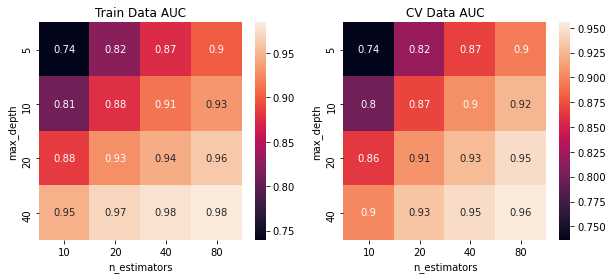

In [27]:
# train classifier on set of parameters and return best parameters after hyperparameter tuning
best_parameters_bow_rf = model(RandomForestClassifier, X_train_bow, Y_train)

In [28]:
depth_bow_rf = best_parameters_bow_rf.max_depth
iter_bow_rf =  best_parameters_bow_rf.n_estimators

# Fit RandomForestClassifier train data with best parameters. 
clf1 =  RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=depth_bow_rf,n_estimators=iter_bow_rf)

# fit RandomForest classifier on train data.            
%time clf1.fit(X_train_bow, Y_train)

Wall time: 1min 28s


RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=80)

In [29]:
# make predictions on both train and test data.
Y_train_predicted, Y_train_predicted_proba, Y_test_predicted, Y_test_predicted_proba = predictions(clf1, X_train_bow, X_test_bow)

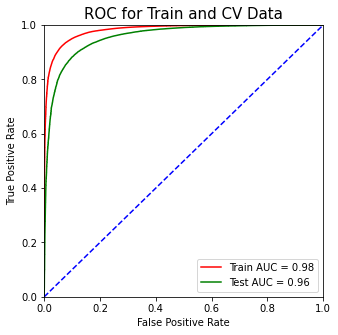

In [30]:
# Plot roc_auc curve for both train and test data.
roc_train_bow_rf, roc_test_bow_rf = roc_auc_curve(Y_train, Y_train_predicted_proba, Y_test, Y_test_predicted_proba)

In [31]:
# generate classification report on test data
acc_bow_rf = classification_report_generator(Y_test, Y_test_predicted)

              precision    recall  f1-score   support

           0       0.71      0.83      0.77     19081
           1       0.96      0.93      0.95     90171

    accuracy                           0.91    109252
   macro avg       0.84      0.88      0.86    109252
weighted avg       0.92      0.91      0.92    109252

_____________________________________________________________________________________________________
Accuracy is = 91.274


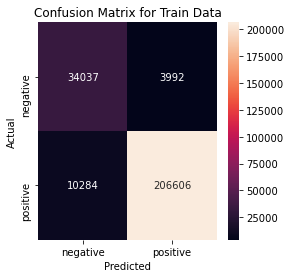

Sensitivity for Train data is : 95.258426
Specificity for Train data is : 89.502748


(95.25842593019503, 89.50274790291618)

In [32]:
# Plot confusion matrix on train data
confusion_matrix_generator(Y_train, Y_train_predicted)

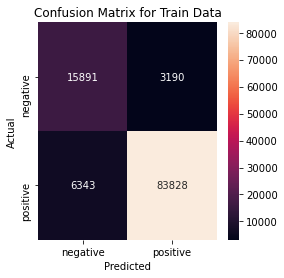

Sensitivity for Train data is : 92.965588
Specificity for Train data is : 83.281799


In [33]:
# Plot confusion matrix on test data
sensivity_bow_rf, specificity_bow_rf = confusion_matrix_generator(Y_test, Y_test_predicted)

In [69]:
# Get most and least important features(words)
feature_importance(vectorizer_bow_1, vectorizer_bow_2)

ValueError: arrays must all be same length

### [6.2] Gradient boost algorithm using XGBoost Classifier on Bag of Words Vectorizer.

Wall time: 31min 13s
1. Best Parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.186, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


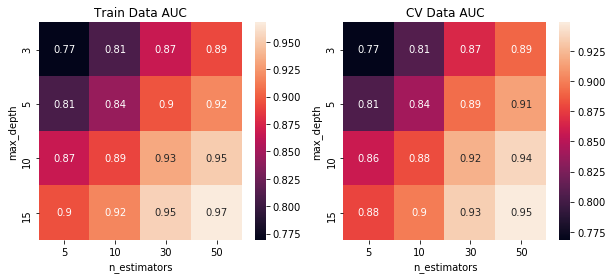

In [32]:
# train classifier on set of parameters and return best parameters after hyperparameter tuning
best_parameters_bow_xgb = model(XGBClassifier, X_train_bow, Y_train)

In [33]:
depth_bow_xgb =  best_parameters_bow_xgb.max_depth
iter_bow_xgb = best_parameters_bow_xgb.n_estimators

# Fit XGBoostClassifier train data with best parameters.
clf2 =  XGBClassifier(max_depth=depth_bow_xgb, n_estimators=iter_bow_xgb, learning_rate=0.1, booster='gbtree', n_jobs=1)

%time clf2.fit(X_train_bow, Y_train)

Wall time: 5min 7s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
# make predictions on both train and test data.
Y_train_predicted, Y_train_predicted_proba, Y_test_predicted, Y_test_predicted_proba = predictions(clf2, X_train_bow, X_test_bow)

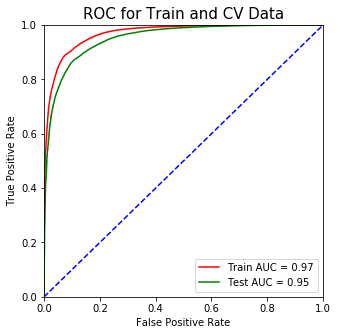

In [35]:
# Plot roc_auc curve for both train and test data.
roc_train_bow_xgb, roc_test_bow_xgb = roc_auc_curve(Y_train, Y_train_predicted_proba, Y_test, Y_test_predicted_proba)

In [36]:
# generate classification report on test data
acc_bow_xgb = classification_report_generator(Y_test, Y_test_predicted)

              precision    recall  f1-score   support

           0       0.90      0.54      0.68     19081
           1       0.91      0.99      0.95     90171

    accuracy                           0.91    109252
   macro avg       0.91      0.77      0.81    109252
weighted avg       0.91      0.91      0.90    109252

_____________________________________________________________________________________________________
Accuracy is = 91.004


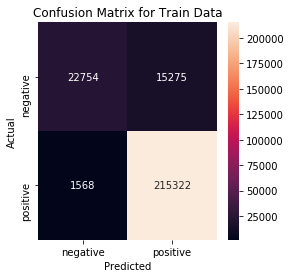

Sensitivity for Train data is : 99.277053
Specificity for Train data is : 59.833285


(99.27705288395039, 59.83328512451024)

In [37]:
# Plot confusion matrix on train data
confusion_matrix_generator(Y_train, Y_train_predicted)

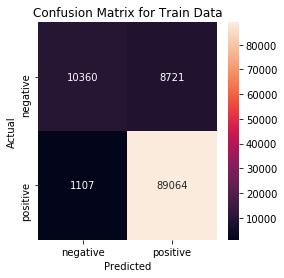

Sensitivity for Train data is : 98.772333
Specificity for Train data is : 54.294848


In [38]:
# Plot confusion matrix on test data
sensivity_bow_xgb, specificity_bow_xgb = confusion_matrix_generator(Y_test, Y_test_predicted)

In [70]:
# Get most and least important features(words)
feature_importance(vectorizer_bow_1, vectorizer_bow_2)

ValueError: arrays must all be same length

# [7] TF-IDF Vectorizer.

In [40]:
# Use TfidfVectorizer to get features from Reviews text
vectorizer_tfidf_1 = TfidfVectorizer()
vectorizer_tfidf_1vectorizer_tfidf_1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vectorizer_tfidf_1.fit(X_train['CleanedText'])
X_train_vec1 = vectorizer_tfidf_1.transform(X_train['CleanedText'])
X_test_vec1 = vectorizer_tfidf_1.transform(X_test['CleanedText'])

print("Sample Features ", vectorizer_tfidf_1.get_feature_names()[:10])

Sample Features  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa']


In [41]:
# Use TfidfVectorizer to get features from Summary text
vectorizer_tfidf_2 = TfidfVectorizer()
vectorizer_tfidf_2 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vectorizer_tfidf_2.fit(X_train['CleanedSummary'])
X_train_vec2 = vectorizer_tfidf_2.transform(X_train['CleanedSummary'])
X_test_vec2 = vectorizer_tfidf_2.transform(X_test['CleanedSummary'])

print("Sample Features ", vectorizer_tfidf_2.get_feature_names()[:10])

Sample Features  ['able', 'able find', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely addictive', 'absolutely amazing', 'absolutely awesome', 'absolutely best']


In [42]:
# stack two sparse matrices using scipy hstack
X_train_tfidf = hstack((X_train_vec1, X_train_vec2))
X_test_tfidf = hstack((X_test_vec1, X_test_vec2))
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(254919, 106273)
(109252, 106273)


### [7.1] RandomForest Classifier on TF-IDF Vectorizer

Wall time: 4min 27s
1. Best Parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


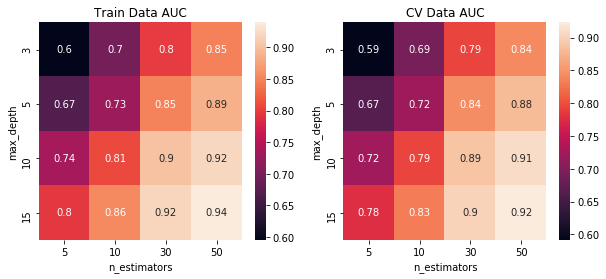

In [43]:
# train classifier on set of parameters and return best parameters after hyperparameter tuning
best_parameters_tfidf_rf = model(RandomForestClassifier, X_train_tfidf, Y_train)

In [44]:
depth_tfidf_rf = best_parameters_tfidf_rf.max_depth
iter_tfidf_rf = best_parameters_tfidf_rf.n_estimators

# Fit RandomForestClassifier train data with best parameters. 
clf3 =  RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=depth_tfidf_rf, n_estimators=iter_tfidf_rf)

# fit RandomForest classifier on train data.            
%time clf3.fit(X_train_tfidf, Y_train)

Wall time: 6.38 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
# make predictions on both train and test data.
Y_train_predicted, Y_train_predicted_proba, Y_test_predicted, Y_test_predicted_proba = predictions(clf3, X_train_tfidf, X_test_tfidf)

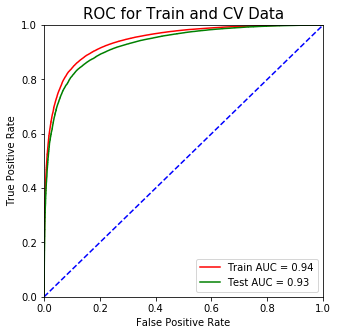

In [46]:
# Plot roc_auc curve for both train and test data.
roc_train_tfidf_rf, roc_test_tfidf_rf = roc_auc_curve(Y_train, Y_train_predicted_proba, Y_test, Y_test_predicted_proba)

In [47]:
# generate classification report on test data
acc_tfidf_rf = classification_report_generator(Y_test, Y_test_predicted)

              precision    recall  f1-score   support

           0       0.56      0.85      0.68     19081
           1       0.96      0.86      0.91     90171

    accuracy                           0.86    109252
   macro avg       0.76      0.86      0.79    109252
weighted avg       0.89      0.86      0.87    109252

_____________________________________________________________________________________________________
Accuracy is = 85.791


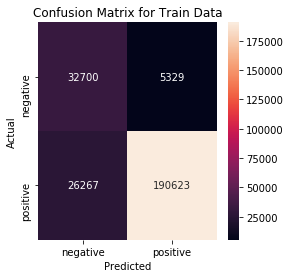

Sensitivity for Train data is : 87.889253
Specificity for Train data is : 85.987010


(87.88925261653372, 85.98700991348707)

In [48]:
# Plot confusion matrix on train data
confusion_matrix_generator(Y_train, Y_train_predicted)

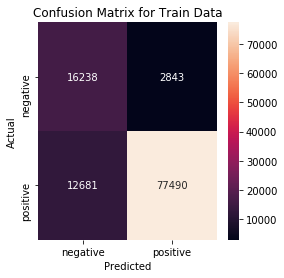

Sensitivity for Train data is : 85.936720
Specificity for Train data is : 85.100362


In [49]:
# Plot confusion matrix on test data
sensivity_tfidf_rf, specificity_tfidf_rf = confusion_matrix_generator(Y_test, Y_test_predicted)

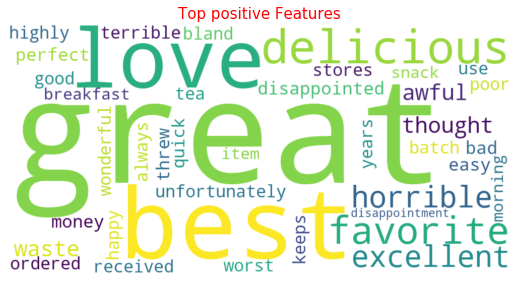

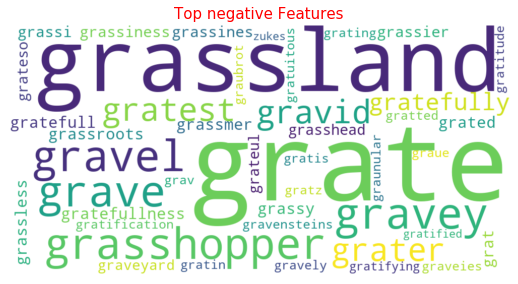

In [50]:
# Get most and least important features(words)
feature_importance(vectorizer_tfidf_1, vectorizer_tfidf_2)

### [7.2] Gradient boost algorithm using XGBoost Classifier on TFIDF Vectorizer.

Wall time: 45min 25s
1. Best Parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.186, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


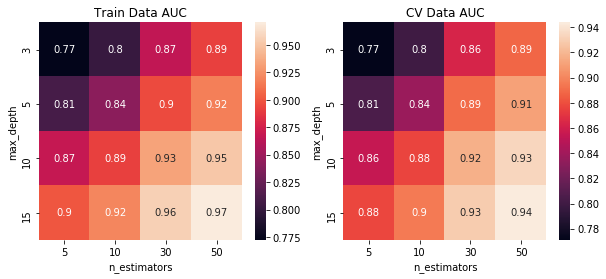

In [51]:
# train classifier on set of parameters and return best parameters after hyperparameter tuning
best_parameters_tfidf_xgb = model(XGBClassifier, X_train_tfidf, Y_train)

In [52]:
depth_tfidf_xgb = best_parameters_tfidf_xgb.max_depth
iter_tfidf_xgb = best_parameters_tfidf_xgb.n_estimators

# Fit XGBoostClassifier train data with best parameters.
clf4 =  XGBClassifier(max_depth=depth_tfidf_xgb, n_estimators=iter_tfidf_xgb, learning_rate=0.1, booster='gbtree', n_jobs=1)

%time clf4.fit(X_train_tfidf, Y_train)

Wall time: 5min 57s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# make predictions on both train and test data.
Y_train_predicted, Y_train_predicted_proba, Y_test_predicted, Y_test_predicted_proba = predictions(clf4, X_train_tfidf, X_test_tfidf)

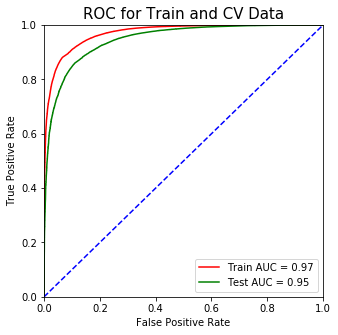

In [54]:
# Plot roc_auc curve for both train and test data.
roc_train_tfidf_xgb, roc_test_tfidf_xgb = roc_auc_curve(Y_train, Y_train_predicted_proba, Y_test, Y_test_predicted_proba)

In [55]:
# generate classification report on test data
acc_tfidf_xgb = classification_report_generator(Y_test, Y_test_predicted)

              precision    recall  f1-score   support

           0       0.89      0.51      0.65     19081
           1       0.91      0.99      0.94     90171

    accuracy                           0.90    109252
   macro avg       0.90      0.75      0.80    109252
weighted avg       0.90      0.90      0.89    109252

_____________________________________________________________________________________________________
Accuracy is = 90.385


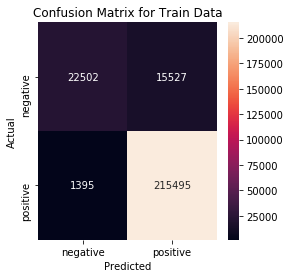

Sensitivity for Train data is : 99.356817
Specificity for Train data is : 59.170633


(99.35681681958597, 59.17063293802099)

In [56]:
# Plot confusion matrix on train data
confusion_matrix_generator(Y_train, Y_train_predicted)

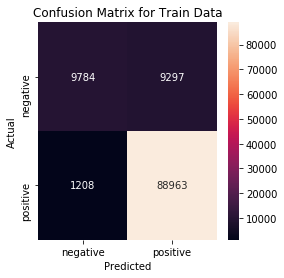

Sensitivity for Train data is : 98.660323
Specificity for Train data is : 51.276139


In [57]:
# Plot confusion matrix on test data
sensivity_tfidf_xgb, specificity_tfidf_xgb = confusion_matrix_generator(Y_test, Y_test_predicted)

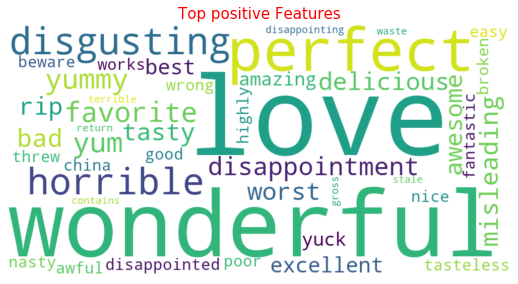

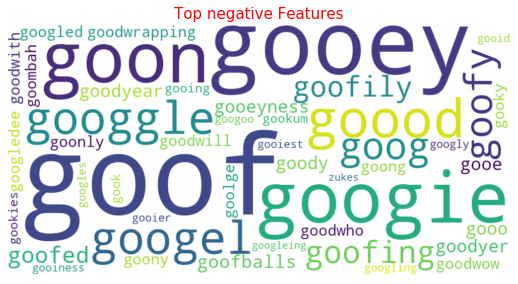

In [58]:
# Get most and least important features(words)
feature_importance(vectorizer_tfidf_1, vectorizer_tfidf_2)

# [8] Model Analysis using Tabular form

In [59]:
# Printing all values in Tabular form
numbering      =   [1,2,3,4]
names          =   ['RF on BoW', 'RF on Tf-Idf', 'XGB on BoW', 'XGB on Tf-Idf']
train_auc      =   [roc_train_bow_rf, roc_train_bow_xgb, roc_train_tfidf_rf, roc_train_tfidf_xgb]
test_auc       =   [roc_test_bow_rf, roc_test_bow_xgb, roc_test_tfidf_rf, roc_test_tfidf_xgb]
accuracy       =   [acc_bow_rf, acc_bow_xgb, acc_tfidf_rf, acc_tfidf_xgb]
optimal_depth  =   [depth_bow_rf, depth_bow_xgb, depth_tfidf_rf, depth_tfidf_xgb]
estimators     =   [iter_bow_rf, iter_bow_xgb, iter_tfidf_rf, iter_tfidf_xgb]
sensitivity    =   [sensivity_bow_rf, sensivity_bow_xgb, sensivity_tfidf_rf, sensivity_tfidf_xgb ]
Specificity    =   [specificity_bow_rf, specificity_bow_xgb, specificity_tfidf_rf, specificity_tfidf_xgb]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.no.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Train AUC", np.round(train_auc, 4))
ptable.add_column("Test AUC",np.round(test_auc, 4))
ptable.add_column("Accuracy",np.round(accuracy, 4))
ptable.add_column("Max Depth",optimal_depth)
ptable.add_column("No. of estimators", estimators)
ptable.add_column("Sensitivity", np.round(sensitivity, 4))
ptable.add_column("Specificity", np.round(Specificity, 4))

ptable.align["MODEL"] = "l"
ptable.align["Train AUC"] = "r"
ptable.align["Test AUC"] = "r"

print(ptable)

+-------+---------------+-----------+----------+----------+-----------+-------------------+-------------+-------------+
| S.no. | MODEL         | Train AUC | Test AUC | Accuracy | Max Depth | No. of estimators | Sensitivity | Specificity |
+-------+---------------+-----------+----------+----------+-----------+-------------------+-------------+-------------+
|   1   | RF on BoW     |    0.9441 |   0.9345 |  87.289  |     15    |         50        |   88.3621   |   82.2179   |
|   2   | RF on Tf-Idf  |    0.9693 |   0.9517 | 91.0043  |     15    |         50        |   98.7723   |   54.2948   |
|   3   | XGB on BoW    |    0.9427 |   0.9294 | 85.7906  |     15    |         50        |   85.9367   |   85.1004   |
|   4   | XGB on Tf-Idf |    0.9707 |   0.9465 | 90.3846  |     15    |         50        |   98.6603   |   51.2761   |
+-------+---------------+-----------+----------+----------+-----------+-------------------+-------------+-------------+


# [9] Observations

1. At first glance Ensemble models seems to perform much better than simple linear models.
2. Every bagging and boosting models trained gives near to perfect ROC-AUC score on training data.
3. Accuracy on bow and tfidf vectorizers is slightly better than word2vec vectorizers and stays over 90% for both Random Forest and XGBoost classifier.
4. Same trend is observed for ROC-AUC score on test data set.
5. Both Random Forest and XGBoost perform well on test data giving as high as .97 auc value.
6. We limited our Max depth and number of estimators to 1000 and 500 respectively but after observing the results it seems better resukts can be achieved by increasing our limit at the expense of computation time.
7. In Random Forest tress grows to full depth ranging between 100 to 1000 whereas in XGBoost trees are shallow reaching upto 10 levels.
8. Number of estimators are same for all models and takes maximum value indicating scope for more number of estimators.
9. All the models give very high sensitivity on test data but story goes same for specificity as it was in linear models.
10. Best model would be XGBoost on bag of words vectorizer as not only it gives best results but also takes similar time to compute as random forest on bow .


In [60]:
import pickle

In [71]:
model_name = 'nlp_model.pkl'
vec1_name = 'bow_text.pkl'
vec2_name = 'bow_summary.pkl'

pickle.dump(clf,open(model_name, 'wb')) # remember to change classifier name
pickle.dump(vectorizer_bow_1,open(vec1_name, 'wb'))  # vectorizer for text field
pickle.dump(vectorizer_bow_2,open(vec2_name, 'wb'))  # vectorizer for summary field

In [34]:
model_name = 'rf_bow_classifier.pkl'
pickle.dump(clf1,open(model_name, 'wb')) 